##Model suggestions from Dr. Bengfort 
1) Gradient Boosting – might want to try them
2) if svc is taking too long then recommend just using Stochastic Gradient Descent or Linear SVC - should improve the performance of the support vector machine and when you are working with support vector machine, make sure your trying polynomial kernels in addition to linear kernels
3) Multinomial naïve bayes if not normally distributed
4) Bayesian classifiers are going to perform the worst – this can be are baseline
5) Smote yellowbrick.target class balance
6) Filter down zero
7) parrell functions



!1) Gaussian Naïve Bayes if features are normally distributed
!2) stick with support vector machines and logistic regression to preserve the linearity of the features  in an understandable way (natural binary classifiers)
!3) Stick with support vector machines and logistic regression
!4) Don’t know if you would get good results from Random Forest and K Near Neighbors, 
!5) Ada boost

In [61]:
import pandas as pd
import boto3
from s3 import get_file

import warnings 

warnings.filterwarnings("ignore")


In [62]:
def data(data):
    df = pd.read_csv(data,sep='|')
    return df

In [63]:
#master_train_playlist.csv

s3 = boto3.resource('s3')

bucket = 's3ssp'

train_data = data(get_file(s3,bucket,download_file='Analysis_Data/new_master_train_playlist.csv',rename_file = 'master_train_playlist.csv'))
test_data = data(get_file(s3,bucket,download_file='Analysis_Data/test_ssp.csv',rename_file = 'test.csv'))


In [64]:
train_data.target.value_counts()

0    373533
1     27533
Name: target, dtype: int64

In [65]:
#Sort columns to be alphabetical order

df_train = train_data.reindex(sorted(train_data.columns), axis=1)
df_test = test_data.reindex(sorted(test_data.columns), axis=1)

In [66]:
df_train = df_train.drop(columns=['playlist','valence','loudness','danceability','energy'
                                 ])

df_test = df_test.drop(columns=['playlist','valence','loudness','danceability','energy'
                               ])

In [67]:
df_train.columns

Index(['acousticness', 'instrumentalness', 'key', 'liveness', 'mode',
       'speechiness', 'target', 'tempo', 'time_signature'],
      dtype='object')

## Pipeline

## Set up Dataset

In [68]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df_train[df_train.target==0]
df_minority = df_train[df_train.target==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=373533,    # to match majority class
                                 random_state=123,) # reproducible results
 
# Combine majority class with upsampled minority class
df_train = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_train.target.value_counts()

1    373533
0    373533
Name: target, dtype: int64

In [69]:
#Structure
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score as cvs
from sklearn.model_selection import StratifiedKFold as KFold
from yellowbrick.model_selection import CVScores


#Kernal
from sklearn.gaussian_process.kernels import RBF


#Classifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#Transform
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler,MinMaxScaler
from sklearn.decomposition import FastICA
from sklearn import preprocessing

#Reports
from yellowbrick.classifier import confusion_matrix,classification_report,DiscriminationThreshold

from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score


X = df_train[[col for col in df_train.columns if col != 'target']]

y = df_train['target']

X_train, X_test, y_train, y_test = tts(X,y, test_size=0.2)

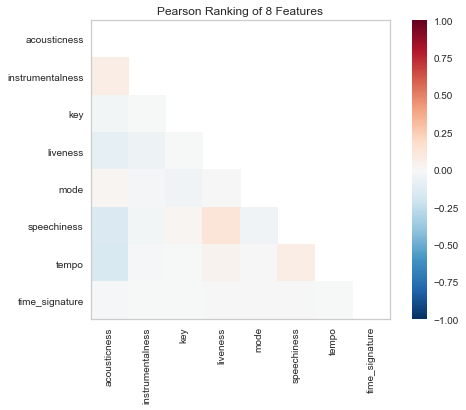

In [70]:
from yellowbrick.datasets import load_credit
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson')

visualizer.fit(X_train, y_train)           # Fit the data to the visualizer
visualizer.transform(X_train)        # Transform the data
visualizer.show()              # Finalize and render the figure

## Initial Model Testing

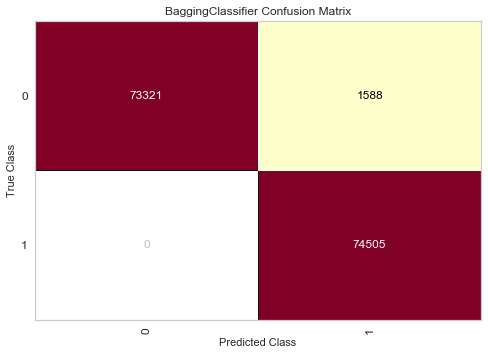

BaggingClassifier
Test CV Score = 0.879797878392397


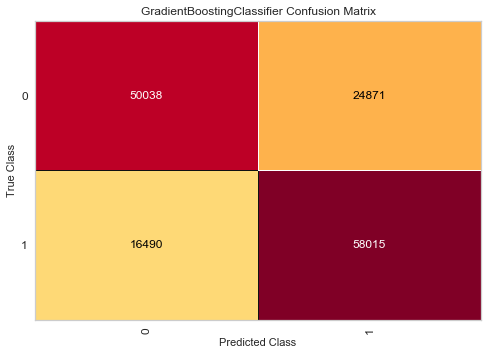

GradientBoostingClassifier
Test CV Score = 0.7233878793963123


In [86]:
scaler = [StandardScaler(), RobustScaler(), MaxAbsScaler(),MinMaxScaler()]

models = [
    #Standard Scaler,QuantileTransformer random_state=0
    
    #Pipeline([
    #        ('std',MinMaxScaler()),
    #        ('reg',LogisticRegression(C=0.01,penalty='l1',solver='liblinear'))
    #]),

    #Pipeline([
    #        ('std',StandardScaler()),
    #        ('mlp',MLPClassifier())
    #]),

    #Does identify positive more than comparison
    #Pipeline([
    #        ('std',MinMaxScaler()),
    #        ('rfc',RandomForestClassifier())
    #]),

    #Too many false positives and negatives    
    #Pipeline([
    #        ('std',MinMaxScaler()),
    #        ('reg',AdaBoostClassifier())
    #]),
    #Robust Scaler leads to false positives above 3000


    #Above 3000 for both false positives
    #Pipeline([
    #    ('std',StandardScaler()),
    #    ('reg',KNeighborsClassifier())
    #]),

    #Pipeline([
    #        ('std',StandardScaler()),
    #        ('reg',DecisionTreeClassifier())
    #]),
        
    #Pipeline([
    #        ('std',StandardScaler()),
    #        ('rc',RidgeClassifier())
    #]),
    
    #Kills Kernal
    
    Pipeline([
            ('std',StandardScaler()),
            ('bc',BaggingClassifier())
    ]),
    
     Pipeline([
            ('std',StandardScaler()),
            ('gbc',GradientBoostingClassifier())
    ]),

    #Above 3000 on false positives

    #Kills Kernal
    #Pipeline([
    #        ('std',StandardScaler()),
    #        ('reg',GaussianProcessClassifier())
    #]),

    #Pipeline([
    #        ('std',StandardScaler()),
    #        ('reg',GaussianNB())
    #]),
    #Pipeline([
    #        ('std',StandardScaler()),
    #        ('reg',QuadraticDiscriminantAnalysis())
    #]),

    
]


a = []

for model in models:
    model.fit(X_train,y_train)
    _ = confusion_matrix(model, X_test, y_test,is_fitted=True)
    #visualizer = DiscriminationThreshold(model)
    #visualizer.fit(X_test, y_test)        # Fit the data to the visualizer
    #visualizer.show()  
    

    
    y_pred = model.predict(X_train)
    model_str = str(model[1])
    print(model_str[0:model_str.find('(',0)].strip())
    #print('Train CV Score = {x} '.format(x=cvs(model,X_train,y_train)[3]))
    print("Test CV Score = {x}".format(x=cvs(model,X_test,y_test)[3]))
    a.append({'Model':model[1],'Transformer':model[0],
              'Test Model Score':cvs(model,X_test,y_test)[3],
              'F1 Score':f1_score(y_train,y_pred),'Precision Score':precision_score(y_train,y_pred),
              'Recall Score':recall_score(y_train,y_pred)})
    


#More complexity led to less precision
#Robust Scaler 
#Pipeline([
#        ('std',RobustScaler()),
#        ('reg',LogisticRegression())
#]),
#Pipeline([
#        ('std',RobustScaler()),
#        ('reg',RandomForestClassifier(n_estimators=50))
#]),



    
#Does identify positive more than comparison
#Pipeline([
#        ('std',StandardScaler()),
#        ('reg',RandomForestClassifier())
#]),
    
#Too many false positives and negatives    
#Pipeline([
#        ('std',StandardScaler()),
#        ('reg',AdaBoostClassifier())
#]),
#Robust Scaler leads to false positives above 3000


#Above 3000 for both false positives
#Pipeline([
#    ('std',StandardScaler()),
#    ('reg',KNeighborsClassifier())
#]),

#Pipeline([
#        ('std',StandardScaler()),
#        ('reg',DecisionTreeClassifier())
#]),

#Above 3000 on false positives

#Kills Kernal
#Pipeline([
#        ('std',StandardScaler()),
#        ('reg',GaussianProcessClassifier())
#]),

#Pipeline([
#        ('std',StandardScaler()),
#        ('reg',GaussianNB())
#]),
#Pipeline([
#        ('std',StandardScaler()),
#        ('reg',QuadraticDiscriminantAnalysis())
#]),





In [87]:
pd.DataFrame(a)

,Model,Transformer,Test Model Score,F1 Score,Precision Score,Recall Score
0,(DecisionTreeClassifier(random_state=259682745...,StandardScaler(),0.879530,0.999866,0.999733,1.000000
1,([DecisionTreeRegressor(criterion='friedman_ms...,StandardScaler(),0.723388,0.738033,0.701716,0.778315


## Grid Search Hyperparameter Tuning

In [98]:
from sklearn.model_selection import GridSearchCV

#learning curve and validation curve 

def params(model):
    model = str(model)
    model = model[:model.find('(',0)]
    
    
    if model == 'LogisticRegression':
        param_grid = {
        'reg__solver':['liblinear'],
        'reg__penalty':['l1'],
        'reg__C':[0.01],  
        }
        return param_grid
    
    elif model == 'RandomForestClassifier':
        param_grid = {
         #   'rfc__max_leaf_nodes':[1000,2000,3000],
         #   'rfc__n_estimators':[100,150,200],
         #   'rfc__criterion':['gini','entropy'],
        'rfc__max_features': [1,2]
        }
        
        return param_grid
    
    elif model == 'RidgeClassifier':
        param_grid = {
            'rc__alpha':[0.1]
        }
        return param_grid
    
    elif model == 'BaggingClassifier':
        param_grid = {
            'bc__n_estimators':[50]
        }
        return param_grid
    
    elif model == 'GradientBoostingClassifier':
        param_grid = {
            
            'gbc__loss':['deviance', 'exponential'],
            'gbc__criterion':['friedman_mse', 'mse', 'mae'],
            
            'gbc__learning_rate':[0.1,0.5,1],
            'gbc__n_estimators':[100,150,200],
        }
        return param_grid
    
    elif model == 'MLPClassifier':
        param_grid = {
        #'mlp__solver':['sgd', 'adam'],
        #'mlp__activation':['identity', 'logistic', 'tanh', 'relu'],
        #'mlp__max_iter':[200,400,600,800,1000],  
        #'mlp__learning_rate':['constant', 'invscaling', 'adaptive'],
        #'mlp__learning_rate_init':['double',0.001,.01,.05,.1],
        #'mlp__power_t':['double',.05,.08,1],
        #'mlp__max_iterint':[200,250,300],
        }
        return param_grid
    
    else:
        return None

            
    
#if mode == 'RandomForestClassifier'


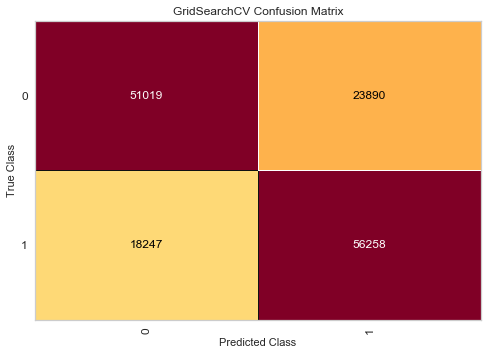

LogisticRegression
Best parameter (CV score=0.7186824470030291
{'reg__C': 0.01, 'reg__penalty': 'l1', 'reg__solver': 'liblinear'}


KeyboardInterrupt: 

In [99]:
models = [
    #Standard Scaler,QuantileTransformer random_state=0
    Pipeline([
            ('std',StandardScaler()),
            ('reg',LogisticRegression())
    ]),

    #Pipeline([
    #        ('std',StandardScaler()),
    #        ('mlp',MLPClassifier())
    #]),
    
    #Pipeline([
    #        ('std',StandardScaler()),
    #        ('rfc',RandomForestClassifier())
    #]),
    
    #Pipeline([
    #        ('std',StandardScaler()),
    #        ('rc',RidgeClassifier())
    #]),
    
    #Pipeline([
    #        ('std',StandardScaler()),
     #       ('bc',BaggingClassifier())
    #]),
    
     Pipeline([
            ('std',StandardScaler()),
            ('gbc',GradientBoostingClassifier())
    ]),
]

for model in models:
    search = GridSearchCV(model,params(model[1]),cv=10)
    search.fit(X_train, y_train)
    _ = confusion_matrix(search, X_test, y_test,is_fitted=True)
    #visualizer = DiscriminationThreshold(model)
    #visualizer.fit(X_test, y_test)        # Fit the data to the visualizer
    #visualizer.show() 
    model_str = str(model[1])
    print(model_str[0:model_str.find('(',0)])
    print("Best parameter (CV score={x}".format(x=search.best_score_))
    print(search.best_params_)
    #model.predict(X_test,y_test)

    a = pd.DataFrame(search.cv_results_)

## Stop

In [ ]:
import matplotlib.pyplot as plt

# Create 2 side-by-side subplots
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

# Instantiate the ConfusionMatrix visualizer for an SVM model

svm_confusion_matrix.fit(X_train, y_train)
svm_confusion_matrix.score(X_test, y_test)

# Create a cross-validation strategy
strategy = StratifiedKFold(n_splits=12, shuffle=True)

# Instantiate the CVScores visualizer for an SVM model
svm_cv_scores = CVScores(
    SVC(),
    scoring="f1_weighted",
    cv=strategy,
    ax=axes[1]
)
svm_cv_scores.fit(X, y)

fig.suptitle("Performance of an SVM model on the occupancy dataset")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Logistical Regression

from sklearn.model_selection import cross_val_score,train_test_split
from yellowbrick.classifier import confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix


X = df_train[[col for col in df_train.columns if col != 'target']]

y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X),y, test_size=0.2)

model = LogisticRegression()
model.fit(X_train, y_train)

_ = confusion_matrix(model, X_test, y_test,is_fitted=True)


#confusion_matrix(X_train, y_train)


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,train_test_split
from yellowbrick.classifier import confusion_matrix,classification_report


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression()
model.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score,train_test_split
from yellowbrick.classifier import confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


X = df_train[[col for col in df_train.columns if col != 'target']]

y = df_train['target']

#Cross
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print(clf.predict)






#confusion_matrix(logreg, X_train, y_train, X_test, y_test)


scores = cross_val_score(clf,X,y)

from sklearn.model_selection import cross_val_score,train_test_split
from yellowbrick.classifier import confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler


X = df_train[[col for col in df_train.columns if col != 'target']]

y = df_train['target']
logreg = LogisticRegression()


#Cross
X_train, X_test, y_train, y_test = train_test_split(RobustScaler().fit_transform(X), y, test_size=0.2)
confusion_matrix(logreg, X_train, y_train, X_test, y_test)



from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn.model_selection import cross_val_score,train_test_split
from yellowbrick.classifier import confusion_matrix,classification_report



#RandomForestRegressor(n_estimators = 50)



#enc = OneHotEncoder(handle_unknown='ignore')
#enc.fit(X)
#enc.categories_


#Support Vector Machine
#estimator = svm.SVC(gamma=.001#,kernel='linear',C=100)

#confusion_matrix(estimator, *train_test_split(X, y, test_size=0.2))
#scores = cross_val_score(estimator,X,y)
#estimator.fit(X,y)
#estimator.predict(df_test)
#Cross value scores
#cross_val_score(X,y)


fromsklearn.neighborsimport KNeighborsClassifierfromsklearn.preprocessingimport StandardScalerfromsklearn.imputeimport SimpleImputerfromsklearn.pipelineimport Pipelinemodel = Pipeline([    ('impute', SimpleImputer(strategy='mean')),     ('scale', StandardScaler()),     ('knn', KNeighborsClassifier(n_neighbors=12))])# Update the hyperparameters of the modelmodel.set_params(knn__weights="distance")model.fit(X_train, y_train)model.score(X_test, y_test)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

model = Pipeline([('scale', StandardScaler()),
                    ('reg',LogisticRegression(fit_intercept=False))
                 ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
confusion_matrix(model.reg, X_train, y_train, X_test, y_test)

# Update the hyperparameters of the model



from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

#X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model = [Pipeline([
    ('scale', StandardScaler()),
    ('reg'),LogisticRegression(fit_intercept=False)
    ]),
]

#check_is_fitted(model,['support_fit_','support_','support_vectors_'])

confusion_matrix(logreg, X_train, y_train, X_test, y_test)

model = Pipeline([
    ('std', StandardScaler()),
    ('reg'),RandomForestRegressor(n_estimator=50)
    ]),
    Pipeline([
    ('std', StandardScaler()),
    ('reg'),MLPRegressor(hidden_layer_sizes=(100,100,100))
    ]),
    Pipeline([
    ('std', RobustScaler()),
    ('reg'),LogisticRegression(fit_intercept=False)
    ]),
    Pipeline([
    ('std', RobustScaler()),
    ('reg'),RandomForestRegressor(n_estimator=50)
    ]),
    Pipeline([
    ('std', RobustScaler()),
    ('reg'),MLPRegressor(hidden_layer_sizes=(100,100,100))
    ]),